In [1180]:
import sys
import torch
import importlib
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad  
import utils_PDE  # Ensure you import the module itself, not specific items
importlib.reload(utils_PDE)  # Reload the module to apply updates
from utils_PDE import *

In [1181]:
def analytic_solution(x_bv, x_loc):
    
    a, x0 = x_bv[:,None,0], x_bv[:,None,1] 
    x, t = x_loc[None,:,0], x_loc[None,:,1] 
    sol = torch.tensor( 3*a**2 / np.cosh((a*(((x + x0) + 1 - a**2*t) % 2 - 1))/2)**2).unsqueeze(-1)
    
    return sol

def get_data(num_bv, num_loc):
    c = np.random.uniform(low=0, high=1, size=(num_bv, 1)).astype(np.float32)
    a = np.random.uniform(low=-1, high=1, size=(num_bv, 1)).astype(np.float32)
    x_bv = np.concatenate((c,a), axis=1)

    t = np.random.uniform(low=0, high=1, size=(num_loc, 1)).astype(np.float32)
    x = np.random.uniform(low=-1, high=1, size=(num_loc, 1)).astype(np.float32)
    x_loc = np.concatenate((x,t), axis=1)

    return analytic_solution(x_bv, x_loc), (x_bv, x_loc)

In [1182]:
# 10 x 10 training points
y_train, X_train = get_data(100, 100)

# 10 x 10 training points
y_test, X_test = get_data(10, 10)


In [ ]:
N = 10
net = SDeepONet([40, 40, 40, 40], [40, 40, 40, 40], N=N, K=N+1, conserve=False)
model = Model(N=N, num_iv=100, num_t=100, net=net)
model.train(iterations=100_001)

Step 	 Train loss 	 Test loss
1000 	 [4.63e-02] 	 [4.70e-02]
2000 	 [3.99e-02] 	 [4.58e-02]
3000 	 [3.86e-02] 	 [4.43e-02]
4000 	 [3.70e-02] 	 [4.22e-02]
5000 	 [3.02e-02] 	 [3.56e-02]
6000 	 [2.76e-02] 	 [3.23e-02]
7000 	 [2.68e-02] 	 [3.09e-02]
8000 	 [2.53e-02] 	 [3.02e-02]
9000 	 [2.44e-02] 	 [2.91e-02]
10000 	 [2.03e-02] 	 [2.41e-02]
11000 	 [1.09e-02] 	 [1.21e-02]
12000 	 [6.61e-03] 	 [7.97e-03]
13000 	 [5.18e-03] 	 [6.54e-03]
14000 	 [3.86e-03] 	 [5.16e-03]
15000 	 [2.77e-03] 	 [4.01e-03]
16000 	 [7.63e-03] 	 [1.06e-02]
17000 	 [2.68e-03] 	 [3.57e-03]
18000 	 [5.39e-03] 	 [5.08e-03]
19000 	 [2.37e-03] 	 [3.59e-03]


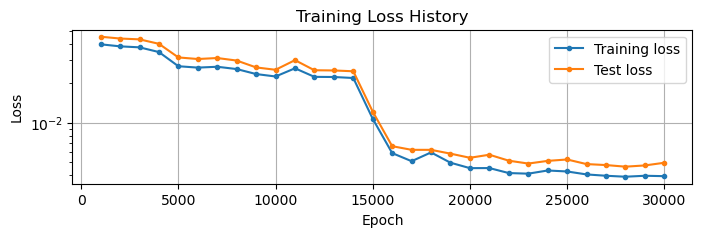

In [1167]:
model.plot_losshistory()

In [1178]:
def plot_conservation(a, x0, dpi=100):
        
        d = torch.concatenate((torch.tensor([1]), np.sqrt(2)*torch.ones(N)))
        P = torch.diag(d).to(torch.complex64)
                    
        # Energy test boundary values
        analytical_integral =  model.I(a) 
        
        t = torch.linspace(0, 1, 100, requires_grad=True)[:,None]        
        iv =  torch.tensor([[a, x0]], dtype=torch.float32)
        
        # Calculate total energy
        u = model.net(iv, t)   
        u = torch.view_as_complex(u.contiguous()) / (2*model.N+1)
        #print(u.shape)
        #print(torch.sum(torch.abs(u)**2, axis=2))
        u = u[0,...].detach()
        #u = torch.concatenate((u, u[...,1:]), dim=1)

  
        integral = 2*(torch.sum(torch.abs(u @ P)**2, axis=1))
        #integral = 2*torch.linalg.norm(u, axis=-1).detach()
        t= t.detach()
        
        _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
        
        ax.set_title('$\int_{\mathbb{T}} u^2(x,t)dx$ over time for $(a, x_0)$=' + f'({a}, {x0})')
        ax.plot(t, torch.ones_like(t)*analytical_integral, alpha=0.5, linewidth=5, label='True')
        ax.plot(t, integral, '--', alpha=0.8, linewidth=3,  label='DeepONet')
        ax.legend()
        ax.grid(True)
        
        ax.set_xlabel("t")
        ax.set_ylabel("$\int_{\mathbb{T}} u^2(x, t)dx$")
        plt.show()

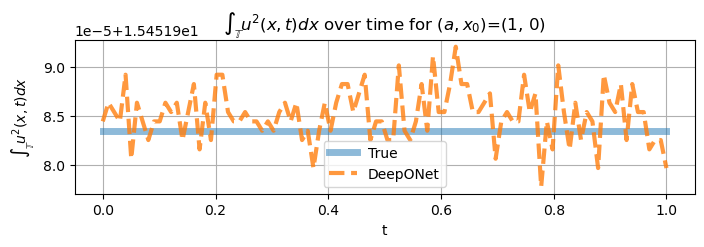

In [ ]:
plot_conservation(a=1,x0=0)

In [1174]:
def plot_predictions(a, x0, T): 
    
    a = np.array(a).astype(np.float32)
    x0 = np.array(x0).astype(np.float32)
    t = np.array([T]).astype(np.float32)
    
    t = np.array([T]).astype(np.float32)
    ground_truth, x = model.analytical_solution(a, x0, t)
    pred = model.predict(a, x0, t)

    pred = np.fft.irfft(pred.detach(), n=2*N+1)


    # Plot prediction vs. solution
    fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

    ax.set_title(f'Prediction of KdV Solution Using a DeepONet (for $t=${T})')


    for l in range(ground_truth.shape[0]):
        label = '({:.1f}, {:.1f})'.format(a[l], x0[l])
        
        ax.plot(x, ground_truth[l,0,:][0:], label=label, alpha=0.3, linewidth=5, c=f'C{l}')
        ax.plot(x, pred[l,0,:].tolist()[0:], '--', c=f'C{l}')

        ax.legend()
        ax.grid(True)
    ax.set_ylabel(f"u(x,{T})")
    ax.set_xlabel("x")
    plt.show()

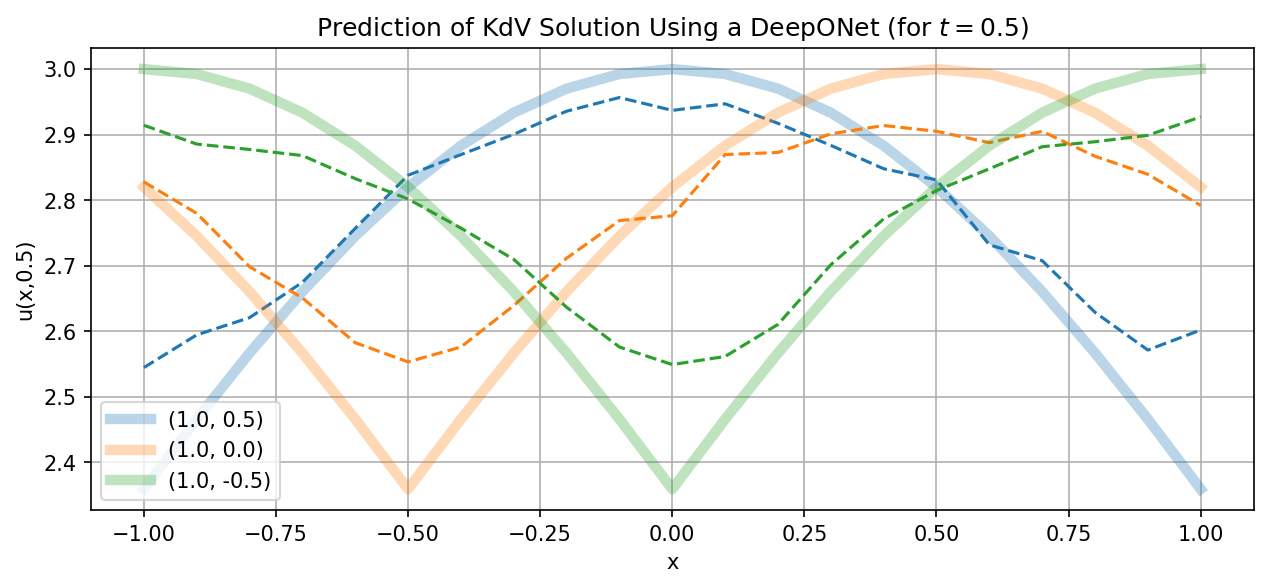

In [1175]:
plot_predictions(a=[1, 1, 1], x0=[0.5, 0, -0.5], T=0.5)